In [1]:
import tensorflow
tensorflow.__version__

/home/Dinnu/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.4.1'

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.5'

In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import zipfile
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing import image

np.random.seed(100)
%matplotlib inline

In [4]:
from bokeh import __version__ as bokeh_version
print("Bokeh - %s" % bokeh_version)              
from seaborn import __version__ as seaborn_version
print("Seaborn - %s" % seaborn_version)

Bokeh - 0.12.15
Seaborn - 0.8.1


In [5]:
# Import the required libraries for seaborn and bokeh

import seaborn as sns
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral5
from bokeh.transform import factor_cmap
output_notebook()

Loading BokehJS ...

In [6]:
rsna_train_label = pd.read_csv('data/boneage-training-dataset.csv', header=0, sep=',')
rsna_test_label = pd.read_csv('data/boneage-test-dataset.csv', header=0, sep=',')

In [7]:
rsna_train_label.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [8]:
# Format male column
rsna_train_label.loc[:,'male'] = pd.Series(rsna_train_label['male'].astype(int))

In [9]:
rsna_train_label.head()

,id,boneage,male
0,1377,180,0
1,1378,12,0
2,1379,94,0
3,1380,120,1
4,1381,82,0


In [10]:
rsna_train_label['male'].value_counts()

1    6833
0    5778
Name: male, dtype: int64

In [11]:
rsna_test_label.head()

,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M
3,4363,M
4,4364,M


In [12]:
rsna_test_label['Sex'].value_counts()

F    100
M    100
Name: Sex, dtype: int64

<IPython.core.display.Javascript object>


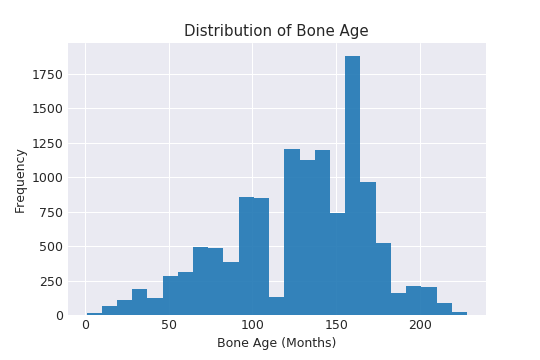

In [13]:
%matplotlib notebook

sns.set_style('darkgrid')
plot = plt.figure()
ax1 = plot.add_subplot(111)
ax1.hist(rsna_train_label['boneage'], alpha=0.9, bins=25)
ax1.set_xlabel('Bone Age (Months)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Bone Age')
plt.show()

In [14]:
# dimensions of our images
img_width, img_height = 400, 400

In [15]:
ROOT_PATH = "data/"
train_data_directory = os.path.join(ROOT_PATH, "boneage-training-dataset")
test_data_directory = os.path.join(ROOT_PATH, "boneage-test-dataset")

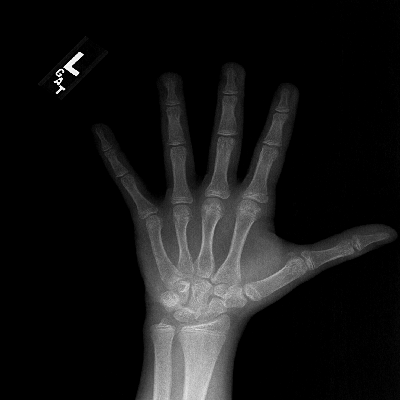

In [16]:
img_path = os.path.join(train_data_directory, '10001.png')
img = image.load_img(img_path, target_size=(img_width, img_height))
img

In [17]:
print(train_data_directory)
print(test_data_directory)

data/boneage-training-dataset
data/boneage-test-dataset


In [18]:
%%time

import os
import cv2
img_files = []
num_imgs = 12611

images_dataFrame = pd.DataFrame(columns=['id', 'image'])
img_files =  os.listdir(train_data_directory)

count = 0
for img_file in img_files[:num_imgs]:
    name = img_file.split('.')[0]
    try:
        img = cv2.imread(train_data_directory + '/' + img_file)
        img = cv2.resize(img, (img_width, img_height))
        #img = np.array(img, dtype='float32')
        images_dataFrame.loc[count] = [name, img]
        count += 1
    except(IOError, OSError):
        print('error')
        pass


CPU times: user 17min 46s, sys: 8.59 s, total: 17min 55s
Wall time: 9min 36s


In [19]:
images_dataFrame.head()

,id,image
0,15344,"[[[17, 17, 17], [16, 16, 16], [16, 16, 16], [1..."
1,6394,"[[[23, 23, 23], [23, 23, 23], [23, 23, 23], [2..."
2,6235,"[[[177, 177, 177], [155, 155, 155], [139, 139,..."
3,7628,"[[[0, 0, 0], [104, 104, 104], [99, 99, 99], [9..."
4,8651,"[[[17, 17, 17], [15, 15, 15], [17, 17, 17], [1..."


In [20]:
images_dataFrame['id'] = images_dataFrame.id.astype('int64')
images_dataFrame['id'].dtype

dtype('int64')

In [21]:
rsna_train_label.head()

,id,boneage,male
0,1377,180,0
1,1378,12,0
2,1379,94,0
3,1380,120,1
4,1381,82,0


In [22]:
rsna_train = pd.merge(rsna_train_label, images_dataFrame, on='id')
rsna_train.head()

,id,boneage,male,image
0,1377,180,0,"[[[237, 237, 237], [240, 240, 240], [241, 241,..."
1,1378,12,0,"[[[130, 130, 130], [128, 128, 128], [128, 128,..."
2,1379,94,0,"[[[129, 129, 129], [129, 129, 129], [128, 128,..."
3,1380,120,1,"[[[65, 65, 65], [60, 60, 60], [62, 62, 62], [5..."
4,1381,82,0,"[[[128, 128, 128], [129, 129, 129], [128, 128,..."


In [23]:
rsna_train = rsna_train.drop(['id'], axis=1)

In [24]:
rsna_train.head()

,boneage,male,image
0,180,0,"[[[237, 237, 237], [240, 240, 240], [241, 241,..."
1,12,0,"[[[130, 130, 130], [128, 128, 128], [128, 128,..."
2,94,0,"[[[129, 129, 129], [129, 129, 129], [128, 128,..."
3,120,1,"[[[65, 65, 65], [60, 60, 60], [62, 62, 62], [5..."
4,82,0,"[[[128, 128, 128], [129, 129, 129], [128, 128,..."


In [25]:
rsna_train['image'].shape

(12611,)

In [26]:
rsna_train['image'][0].shape

(400, 400, 3)

In [27]:
rsna = rsna_train['image']

In [28]:
rsna.shape

(12611,)

In [29]:
rsna.head()

0    [[[237, 237, 237], [240, 240, 240], [241, 241,...
1    [[[130, 130, 130], [128, 128, 128], [128, 128,...
2    [[[129, 129, 129], [129, 129, 129], [128, 128,...
3    [[[65, 65, 65], [60, 60, 60], [62, 62, 62], [5...
4    [[[128, 128, 128], [129, 129, 129], [128, 128,...
Name: image, dtype: object

In [30]:
rsna[0].shape

(400, 400, 3)

In [31]:
images = []
for i, x in rsna_train.iterrows():
    images.append(rsna_train.loc[i, 'image'])
    
#X_train = np.array(images, dtype='float32')

In [32]:
len(images)

12611

In [33]:
images[0].shape

(400, 400, 3)

In [34]:
X_train = np.array(images, dtype='float32')

In [35]:
X_train.shape

(12611, 400, 400, 3)

In [36]:
gender = rsna_train['male'].values

In [37]:
bone_age = rsna_train['boneage'].values

In [38]:
y_train = rsna_train['boneage'].values
y_train.shape

(12611,)

In [39]:
# Normalize the data

#X_train /= 255

In [40]:
X_train.shape

(12611, 400, 400, 3)

In [41]:
%%time

#np.save('data/X_train_won.npy', X_train)
#X_train = np.load('.../X_train_won.npy')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [42]:
%%time

#X_train = np.load('data/X_train_won.npy')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [43]:
#X_train /= 255

In [44]:
from keras.preprocessing.image import ImageDataGenerator

print("Augment the training dataset...")
train_data_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False)

val_data_gen = ImageDataGenerator(rescale = 1./255)

def gen_train_two_inputs(x, y, z):
    X1 = train_data_gen.flow(x, y, batch_size=batch_size, seed=20)
    X2 = train_data_gen.flow(x, z, batch_size=batch_size, seed=20)
    while True:
        X1i = X1.next()
        X2i = X2.next()
        yield [X1i[0], X1i[1]], X2i[1]
        
def gen_val_two_inputs(x, y, z):
    X1 = val_data_gen.flow(x, y, batch_size=batch_size, seed=20)
    X2 = val_data_gen.flow(x, z, batch_size=batch_size, seed=20)
    while True:
        X1i = X1.next()
        X2i = X2.next()
        yield [X1i[0], X1i[1]], X2i[1]

Augment the training dataset...


In [45]:
train_size = int(.85 * num_imgs)
train_gen_flow = gen_train_two_inputs(X_train[:train_size], gender[:train_size], bone_age[:train_size])
val_gen_flow = gen_val_two_inputs(X_train[train_size:], gender[train_size:], bone_age[train_size:])

In [46]:
train_size

10719

In [47]:
len(X_train[train_size:])

1892

In [48]:
len(X_train[:train_size])

10719

In [49]:
%%time

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.metrics import mean_absolute_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

v3_model = InceptionV3(input_shape = X_train.shape[1:], include_top = False, weights = 'imagenet')
#v3_model.trainable = True


for i, layer in enumerate(v3_model.layers):
    print(i, layer.name)

    # we chose to train the top 5 inception blocks, i.e. we will freeze
# the first 108 layers and unfreeze the rest:

for layer in v3_model.layers[:108]:
    layer.trainable = False
for layer in v3_model.layers[108:]:
    layer.trainable = True
    
    
images_branch = v3_model.output
images_branch = Flatten()(images_branch)

new_model = Model(inputs=v3_model.input, outputs=images_branch)

age_branch = Sequential()
age_branch.add(Dense(64, input_shape=(1,), activation='relu'))

# merged = Merge([new_model, text_branch], mode='concat')
merged = keras.layers.concatenate([new_model.output, age_branch.output])

age = Dense(1000, activation='relu')(merged)
age = Dense(1000, activation='relu')(age)
age = Dense(1)(age)

# show model
# model.summary()
model = Model(inputs=[v3_model.input, age_branch.input], outputs=age)


0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [50]:
%%time

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 199, 199, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 199, 199, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 199, 199, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [51]:
%%time
validation_split = 0.2
nb_epoch = 30
batch_size = 32

#optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) 
#model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae', 'acc'])

CPU times: user 33.1 ms, sys: 4.03 ms, total: 37.2 ms
Wall time: 31 ms


In [52]:
# Call backs
#save_best = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00005) 

In [53]:
%%time

# fit data
history = model.fit_generator(
          train_gen_flow,
          steps_per_epoch=250,
          epochs=110,
          validation_data=val_gen_flow,
          validation_steps=60,
          callbacks=[reduceLROnPlat]
          )

Epoch 1/110
250/250 [==============================] - 531s 2s/step - loss: 2102.6402 - mean_absolute_error: 24.6406 - acc: 0.0164 - val_loss: 442.8659 - val_mean_absolute_error: 16.7828 - val_acc: 0.0243
Epoch 2/110
250/250 [==============================] - 503s 2s/step - loss: 387.6129 - mean_absolute_error: 15.6625 - acc: 0.0216 - val_loss: 327.9246 - val_mean_absolute_error: 14.7259 - val_acc: 0.0233
Epoch 3/110
250/250 [==============================] - 523s 2s/step - loss: 373.1863 - mean_absolute_error: 15.3194 - acc: 0.0223 - val_loss: 282.5542 - val_mean_absolute_error: 13.8396 - val_acc: 0.0148
Epoch 4/110
250/250 [==============================] - 523s 2s/step - loss: 251.0737 - mean_absolute_error: 12.4946 - acc: 0.0249 - val_loss: 165.0402 - val_mean_absolute_error: 10.1780 - val_acc: 0.0270
Epoch 5/110
250/250 [==============================] - 521s 2s/step - loss: 212.8304 - mean_absolute_error: 11.4901 - acc: 0.0299 - val_loss: 152.7651 - val_mean_absolute_error: 9.708

Epoch 40/110
250/250 [==============================] - 518s 2s/step - loss: 85.7134 - mean_absolute_error: 7.1347 - acc: 0.0503 - val_loss: 199.7549 - val_mean_absolute_error: 10.8973 - val_acc: 0.0285
Epoch 41/110
250/250 [==============================] - 509s 2s/step - loss: 87.1607 - mean_absolute_error: 7.2555 - acc: 0.0516 - val_loss: 164.3787 - val_mean_absolute_error: 10.5058 - val_acc: 0.0322
Epoch 42/110
250/250 [==============================] - 512s 2s/step - loss: 92.2320 - mean_absolute_error: 7.3801 - acc: 0.0450 - val_loss: 177.2009 - val_mean_absolute_error: 10.3400 - val_acc: 0.0344
Epoch 43/110
250/250 [==============================] - 509s 2s/step - loss: 86.3437 - mean_absolute_error: 7.2094 - acc: 0.0485 - val_loss: 166.6333 - val_mean_absolute_error: 10.3646 - val_acc: 0.0280

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
Epoch 44/110
250/250 [==============================] - 517s 2s/step - loss: 83.0557 - mean_absolute_error

250/250 [==============================] - 520s 2s/step - loss: 54.7833 - mean_absolute_error: 5.7627 - acc: 0.0588 - val_loss: 115.2719 - val_mean_absolute_error: 8.4451 - val_acc: 0.0391
Epoch 79/110
250/250 [==============================] - 514s 2s/step - loss: 53.8943 - mean_absolute_error: 5.7091 - acc: 0.0544 - val_loss: 119.1427 - val_mean_absolute_error: 8.3588 - val_acc: 0.0338
Epoch 80/110
250/250 [==============================] - 516s 2s/step - loss: 54.8801 - mean_absolute_error: 5.6873 - acc: 0.0638 - val_loss: 121.7216 - val_mean_absolute_error: 8.3871 - val_acc: 0.0412
Epoch 81/110
250/250 [==============================] - 509s 2s/step - loss: 51.5045 - mean_absolute_error: 5.5557 - acc: 0.0595 - val_loss: 110.7162 - val_mean_absolute_error: 8.0150 - val_acc: 0.0529
Epoch 82/110
250/250 [==============================] - 522s 2s/step - loss: 52.1809 - mean_absolute_error: 5.5615 - acc: 0.0583 - val_loss: 104.9786 - val_mean_absolute_error: 7.7525 - val_acc: 0.0407
Epo

In [ ]:
model.save('inception_boneage_final.h5')

<IPython.core.display.Javascript object>


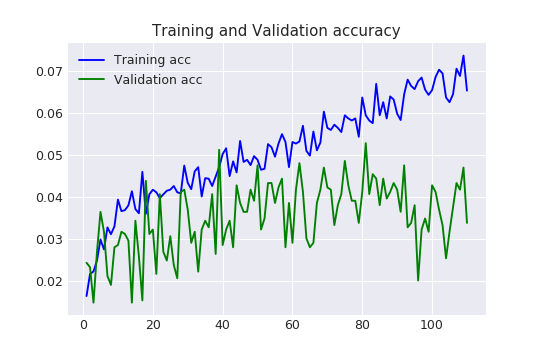

<IPython.core.display.Javascript object>


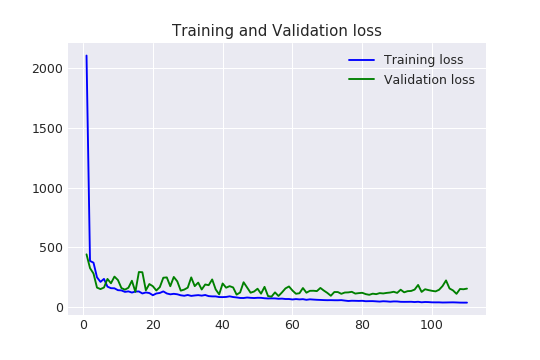

<IPython.core.display.Javascript object>


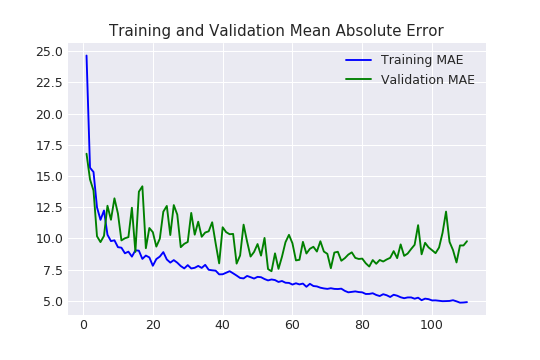

In [63]:
%matplotlib notebook

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
mean_absolute_error = history.history['mean_absolute_error']
val_mean_absolute_error = history.history['val_mean_absolute_error']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, mean_absolute_error, 'b', label='Training MAE')
plt.plot(epochs, val_mean_absolute_error, 'g', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.legend()
plt.show()


#val_mean_absolute_error

In [54]:
%%time

import os
import cv2
img_files = []
num_imgs = 200

images_test = pd.DataFrame(columns=['id', 'image'])
img_files =  os.listdir(test_data_directory)

count = 0
for img_file in img_files[:num_imgs]:
    name = img_file.split('.')[0]
    try:
        img = cv2.imread(test_data_directory + '/' + img_file)
        img = cv2.resize(img, (img_width, img_height))
        #img = np.array(img, dtype='float32')
        images_test.loc[count] = [name, img]
        count += 1
    except(IOError, OSError):
        print('error')
        pass

CPU times: user 16.7 s, sys: 117 ms, total: 16.8 s
Wall time: 9.08 s


In [55]:
images_test.head()

,id,image
0,4541,"[[[94, 94, 94], [94, 94, 94], [94, 94, 94], [8..."
1,4544,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,4402,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,4393,"[[[63, 63, 63], [64, 64, 64], [66, 66, 66], [6..."
4,4433,"[[[76, 76, 76], [78, 78, 78], [79, 79, 79], [8..."


In [56]:
images_test['id'] = images_test.id.astype('int64')
images_test['id'].dtype

dtype('int64')

In [57]:
rsna_test_label.head()

,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M
3,4363,M
4,4364,M


In [58]:
# Format male column
rsna_test_label['Sex'].replace(['F','M'],[0,1], inplace=True)

In [59]:
rsna_test_label.head()

,Case ID,Sex
0,4360,1
1,4361,1
2,4362,1
3,4363,1
4,4364,1


In [60]:
rsna_test_data = pd.merge(rsna_test_label, images_test, left_on='Case ID', right_on='id')
rsna_test_data.head()

,Case ID,Sex,id,image
0,4360,1,4360,"[[[191, 191, 191], [255, 255, 255], [255, 255,..."
1,4361,1,4361,"[[[67, 67, 67], [74, 74, 74], [73, 73, 73], [7..."
2,4362,1,4362,"[[[12, 12, 12], [13, 13, 13], [13, 13, 13], [9..."
3,4363,1,4363,"[[[73, 73, 73], [52, 52, 52], [46, 46, 46], [5..."
4,4364,1,4364,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [61]:
rsna_test_data = rsna_test_data.drop(['id'], axis=1)
rsna_test_data = rsna_test_data.drop(['Case ID'], axis=1)

In [62]:
rsna_test_data.head()

,Sex,image
0,1,"[[[191, 191, 191], [255, 255, 255], [255, 255,..."
1,1,"[[[67, 67, 67], [74, 74, 74], [73, 73, 73], [7..."
2,1,"[[[12, 12, 12], [13, 13, 13], [13, 13, 13], [9..."
3,1,"[[[73, 73, 73], [52, 52, 52], [46, 46, 46], [5..."
4,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [63]:
rsna_test_data['image'].shape

(200,)

In [64]:
rsna_test = rsna_test_data['image']

In [65]:
rsna_test.shape

(200,)

In [66]:
rsna_test.head()

0    [[[191, 191, 191], [255, 255, 255], [255, 255,...
1    [[[67, 67, 67], [74, 74, 74], [73, 73, 73], [7...
2    [[[12, 12, 12], [13, 13, 13], [13, 13, 13], [9...
3    [[[73, 73, 73], [52, 52, 52], [46, 46, 46], [5...
4    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
Name: image, dtype: object

In [67]:
images = []
for i, x in rsna_test_data.iterrows():
    images.append(rsna_test_data.loc[i, 'image'])
    
#X_train = np.array(images, dtype='float32')

In [68]:
len(images)

200

In [69]:
X_test = np.array(images, dtype='float32')

In [70]:
X_test.shape

(200, 400, 400, 3)

In [71]:
gender_test = rsna_test_data['Sex'].values

In [133]:
#X_test /= 255

In [72]:
X_test.shape

(200, 400, 400, 3)

In [73]:
rsna_test_label.head()

,Case ID,Sex
0,4360,1
1,4361,1
2,4362,1
3,4363,1
4,4364,1


In [74]:
test_data_gen = ImageDataGenerator(rescale = 1./255)
batch_size = 32

def gen_test_two_inputs(x, y, z):
    X1 = test_data_gen.flow(x, y, batch_size=batch_size, seed=20)
    X2 = test_data_gen.flow(x, z, batch_size=batch_size, seed=20)
    while True:
        X1i = X1.next()
        X2i = X2.next()
        yield [X1i[0], X1i[1]], X2i[1]

In [ ]:
#test_gen_flow = gen_train_two_inputs(X_test[:train_size], gender[:train_size], bone_age[:train_size])

In [ ]:
# Score trained model.
#scores = model.evaluate(X_test, y_test, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])

In [75]:
output = model.predict([X_test, gender_test])

In [76]:
output

array([[1197.5704 ],
       [1391.6047 ],
       [2773.5442 ],
       [1315.7936 ],
       [ 995.42535],
       [ 890.1759 ],
       [1366.6282 ],
       [1212.3193 ],
       [1116.2092 ],
       [2981.1438 ],
       [3637.9487 ],
       [3028.1472 ],
       [ 970.1939 ],
       [1197.5153 ],
       [1129.3778 ],
       [1364.6188 ],
       [1421.404  ],
       [2489.2954 ],
       [ 990.3096 ],
       [4411.621  ],
       [2656.584  ],
       [1927.2616 ],
       [1304.5347 ],
       [1097.0981 ],
       [ 998.30225],
       [ 578.2273 ],
       [1326.2272 ],
       [1397.9415 ],
       [3328.136  ],
       [1577.7638 ],
       [2827.8953 ],
       [1257.9076 ],
       [1313.2859 ],
       [ 742.75714],
       [1215.7375 ],
       [1041.3165 ],
       [ 697.52515],
       [1340.6316 ],
       [2118.4019 ],
       [1245.8276 ],
       [1623.6946 ],
       [1690.6056 ],
       [1760.7338 ],
       [3791.3018 ],
       [1451.8956 ],
       [1322.124  ],
       [1077.1234 ],
       [1151.

In [ ]:
def alincc(x,y):
    """
Calculates Lin's concordance correlation coefficient.
Usage:   alincc(x,y)    where x, y are equal-length arrays
Returns: Lin's CC
"""
    x = N.ravel(x)
    y = N.ravel(y)
    covar = acov(x,y)*(len(x)-1)/float(len(x))  # correct denom to n
    xvar = avar(x)*(len(x)-1)/float(len(x))  # correct denom to n
    yvar = avar(y)*(len(y)-1)/float(len(y))  # correct denom to n
    lincc = (2 * covar) / ((xvar+yvar) +((amean(x)-amean(y))**2))
    return lincc